_Lambda School Data Science — Regression 2_

# Evaluating Forecasts

#### Objectives
- explain why overfitting is a problem and model validation is important
- do train/test split
- use time series metrics: MSE, RMSE, MAE, MAPE
- do time series cross-validation

## Example solutions for stretch goals

### Use the Wikimedia Pageviews API to get data
- Get good at learning new things by googling and reading documentation. Jake Vander Plas calls this ["the real world bootcamp"](https://twitter.com/jakevdp/status/648593367786323968).
- To learn how to get data from an API, follow along with the [Requests library quickstart](https://2.python-requests.org/en/master/user/quickstart/), or [_Automate the Boring Stuff with Python_, Chapter 14](https://automatetheboringstuff.com/chapter14/) by Al Swiegart.
- Then, refer to the [Wikipedia Pageviews API quickstart](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews#Quick_start) and [documentation](https://wikimedia.org/api/rest_v1/#/Pageviews%20data).

In [113]:
%matplotlib inline
import pandas as pd
import requests

project = 'en.wikipedia'
access = 'all-access'
agent = 'user'
article = 'Veganism'
granularity = 'daily'
start = '20150701'
end = '20190527'

endpoint = f'/metrics/pageviews/per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'
url = 'https://wikimedia.org/api/rest_v1' + endpoint
response = requests.get(url)
assert response.status_code == 200
df = pd.DataFrame(response.json()['items'])
df = df.rename(columns={'timestamp':'ds', 'views':'y'})
df['ds'] = pd.to_datetime(df['ds'], format='%Y%m%d%H')

### Adjust your forecasts with Prophet's changepoints and holidays options

#### Prophet documentation: [Trend Changepoints](https://facebook.github.io/prophet/docs/trend_changepoints.html)

> Real time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use.

#### Prophet documentation: [Holiday Effects](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html)

> If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them. It has two columns (`holiday` and `ds`) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). 

#### Model holidays, plot changepoints

In [3]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

holidays = pd.DataFrame({
  'holiday': 'new_years',
  'ds': pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', 
                        '2019-01-01, 2020-01-01', '2021-01-01'], utc=True),
  'lower_window': -5,
  'upper_window': 5,
})

model = Prophet(daily_seasonality=False, holidays=holidays)
model.fit(df)
future = model.make_future_dataframe(periods=365*2)
forecast = model.predict(future)
fig1 = model.plot(forecast)
add_changepoints_to_plot(fig1.gca(), model, forecast)
fig2 = model.plot_components(forecast)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
/Users/dwightchurchill/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


AttributeError: 'NoneType' object has no attribute '_can_consolidate'

#### Will Koehrsen's blog post, [Time Series Analysis in Python](https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a)

> When creating the prophet models, I set the changepoint prior to 0.15, up from the default value of 0.05. This hyperparameter is used to control [how sensitive the trend is to changes](https://facebook.github.io/prophet/docs/trend_changepoints.html), with a higher value being more sensitive and a lower value less sensitive. This value is used to combat one of the most fundamental trade-offs in machine learning: [bias vs. variance](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff).

> If we fit too closely to our training data, called [overfitting](https://elitedatascience.com/overfitting-in-machine-learning), we have too much variance and our model will not be able to generalize well to new data. On the other hand, if our model does not capture the trends in our training data it is underfitting and has too much bias. When a model is underfitting, increasing the changepoint prior allows more flexibility for the model to fit the data, and if the model is overfitting, decreasing the prior limits the amount of flexibility. 

#### Adjust the `changepoint_prior_scale` parameter

In [22]:
import matplotlib.pyplot as plt

scales = [0.01, 0.05, 0.15, 0.50]
for scale in scales:
    model = Prophet(daily_seasonality=False, holidays=holidays, 
                    changepoint_prior_scale=scale)
    model.fit(df)
    future = model.make_future_dataframe(periods=365*2)
    forecast = model.predict(future)
    fig1 = model.plot(forecast)
    add_changepoints_to_plot(fig1.gca(), model, forecast)
    plt.title(f'changepoint_prior_scale={scale}')
    plt.show()

/Users/dwightchurchill/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


AttributeError: 'NoneType' object has no attribute '_can_consolidate'

***How can we know if our model is good? How should we adjust the right parameters?***

*We do model validation!*

## Explain why overfitting is a problem and model validation is important

#### Jason Brownlee, [Overfitting and Underfitting With Machine Learning Algorithms](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/)

> The goal of a good machine learning model is to **generalize** well from the training data to any data from the problem domain. This allows us to make predictions in the future on data the model has never seen.

> The cause of poor performance in machine learning is either overfitting or underfitting the data.

> **Overfitting** refers to a model that models the training data too well. Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. 

> **Underfitting** refers to a model that can neither model the training data nor generalize to new data.

> Ideally, you want to select a model at the sweet spot between underfitting and overfitting.

#### Rob Hyndman & George Athanasopoulos, [_Forecasting: Principles and Practice_, Chapter 3.4](https://otexts.com/fpp2/accuracy.html), Evaluating forecast accuracy:

> The following points should be noted.

> - A model which fits the training data well will not necessarily forecast well.
> - A perfect fit can always be obtained by using a model with enough parameters.
> - Over-fitting a model to data is just as bad as failing to identify a systematic pattern in the data.

> **The accuracy of forecasts can only be determined by considering how well a model performs on new data that were not used when fitting the model.**

> When choosing models, it is common practice to separate the available data into two portions, training and test data, where the training data is used to estimate any parameters of a forecasting method and the test data is used to evaluate its accuracy. Because the test data is not used in determining the forecasts, it should provide a reliable indication of how well the model is likely to forecast on new data.

![](https://otexts.com/fpp2/fpp_files/figure-html/traintest-1.png)

> The size of the test set is typically about 20% of the total sample, although this value depends on how long the sample is and how far ahead you want to forecast. The test set should ideally be at least as large as the maximum forecast horizon required.

> Some references describe the test set as the “hold-out set” because these data are “held out” of the data used for fitting. Other references call the training set the “in-sample data” and the test set the “out-of-sample data”. We prefer to use “training data” and “test data” in this book.

#### James, Witten, Hastie, Tibshirani, [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 2.2, Assessing Model Accuracy

> In general, we do not really care how well the method works training on the training data. Rather, _we are interested in the accuracy of the predictions that we obtain when we apply our method to previously unseen test data._ Why is this what we care about? 

> Suppose that we are interested test data in developing an algorithm to predict a stock’s price based on previous stock returns. We can train the method using stock returns from the past 6 months. But we don’t really care how well our method predicts last week’s stock price. We instead care about how well it will predict tomorrow’s price or next month’s price. 

> On a similar note, suppose that we have clinical measurements (e.g. weight, blood pressure, height, age, family history of disease) for a number of patients, as well as information about whether each patient has diabetes. We can use these patients to train a statistical learning method to predict risk of diabetes based on clinical measurements. In practice, we want this method to accurately predict diabetes risk for _future patients_ based on their clinical measurements. We are not very interested in whether or not the method accurately predicts diabetes risk for patients used to train the model, since we already know which of those patients have diabetes.

#### Rachel Thomas, [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)

> An all-too-common scenario: a seemingly impressive machine learning model is a complete failure when implemented in production. The fallout includes leaders who are now skeptical of machine learning and reluctant to try it again. How can this happen?

> One of the most likely culprits for this disconnect between results in development vs results in production is a poorly chosen validation set (or even worse, no validation set at all). 

#### Owen Zhang, [Winning Data Science Competitions](https://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions/8)

> Good validation is _more important_ than good models. 



## Do train/test split

### Read weather data
- This was another stretch goal from the previous notebook: You can [get daily weather station data](https://www.ncdc.noaa.gov/cdo-web/search) from the NOAA (National Oceanic and Atmospheric Administration) for your local area. 

In [5]:
url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Regression-1/master/module2-evaluating-forecasts/weather-normal-il.csv'
weather = (pd.read_csv(url, parse_dates=['DATE'])
             .rename(columns={'DATE':'ds', 'TMAX':'y'}))



### Split the weather data: train with 2010-17, and test with 2018-19

In [9]:
weather = weather.set_index('ds')

In [12]:
train = weather['2010':'2017']
test = weather['2018':'2019']

In [15]:
train = train.reset_index()
test = test.reset_index()

In [16]:
train.head()

,ds,STATION,LATITUDE,LONGITUDE,PRCP,y,TMIN
0,2010-01-01,USC00116200,40.5493,-88.9501,0.0,33.0,-1.0
1,2010-01-02,USC00116200,40.5493,-88.9501,0.0,13.0,-6.0
2,2010-01-03,USC00116200,40.5493,-88.9501,0.0,10.0,-10.0
3,2010-01-04,USC00116200,40.5493,-88.9501,0.0,12.0,-10.0
4,2010-01-05,USC00116200,40.5493,-88.9501,0.0,10.0,-4.0


### Plot daily high temperatures for train (blue) and test (red)

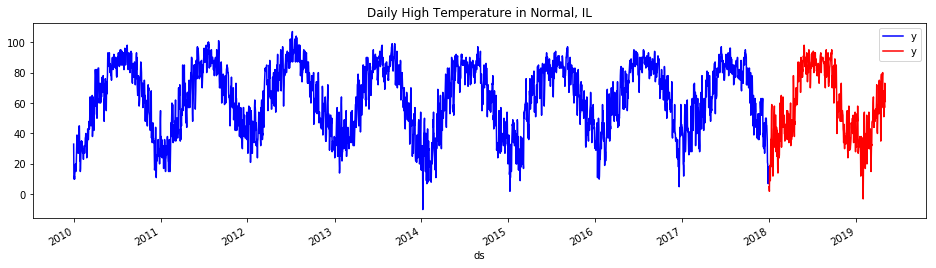

In [24]:
ax = train.plot(x='ds',y='y',color='blue',figsize=(16,4))
test.plot(x='ds',y='y',color='red',ax=ax)
plt.title('Daily High Temperature in Normal, IL');

## Begin with baselines for time series

### Mean Baseline

In [26]:
train['mean_baseline'] = train['y'].mean()
test['mean_baseline'] = train['y'].mean()

In [27]:
train['y'].mean(), test['y'].mean()

(62.9100310237849, 57.700205338809035)

In [29]:
print('Average daily high temperature in the train set:', train['y'].mean())

Average daily high temperature in the train set: 62.9100310237849


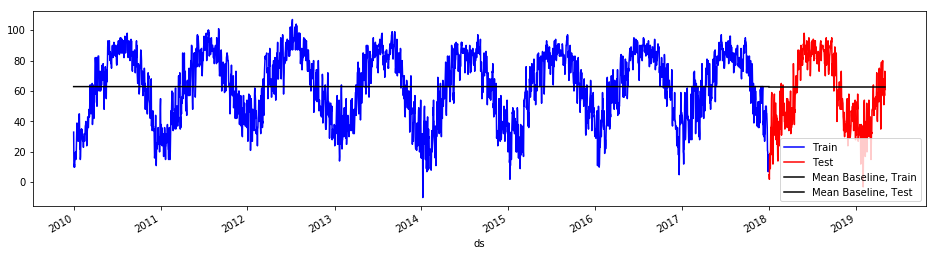

In [32]:
ax = train.plot(x='ds', y='y', color='blue', label='Train', figsize=(16,4))
test.plot(x='ds',y='y',color='red',label='Test',ax=ax)
train.plot(x='ds',y='mean_baseline', color='black',label='Mean Baseline, Train',ax=ax)
test.plot(x='ds',y='mean_baseline',color='black',label='Mean Baseline, Test',ax=ax);

### Naive Baseline (Last Observation)

In [44]:
train['naive_baseline'] = train['y'].shift(1).bfill()
train_last_observation = train['naive_baseline'].iloc[-1]
test['naive_baseline'] = train_last_observation

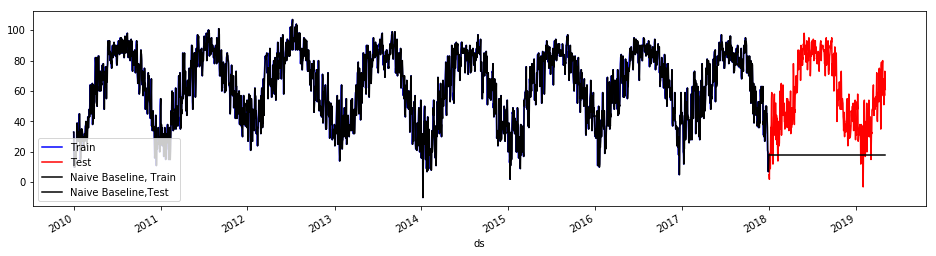

In [46]:
ax = train.plot(x='ds', y='y', color='blue', label='Train', figsize=(16,4))
test.plot(x='ds',y='y',color='red',label='Test',ax=ax)
train.plot(x='ds',y='naive_baseline', color='black',label='Naive Baseline, Train',ax=ax)
test.plot(x='ds',y='naive_baseline', color='black',label='Naive Baseline,Test', ax=ax);

## Use time series metric: MAE (Mean Absolute Error)

#### Rob Hyndman & George Athanasopoulos, [_Forecasting: Principles and Practice_, Chapter 3.4](https://otexts.com/fpp2/accuracy.html), Evaluating forecast accuracy:

> A forecast “error” is the difference between an observed value and its forecast.

> We can measure forecast accuracy by summarising the forecast errors in different ways.

> The two most commonly used scale-dependent measures are based on the absolute errors or squared errors:

> Mean absolute error: $\mathrm{MAE}=\operatorname{mean}\left(\left|e_{t}\right|\right)$

> Root mean squared error: $\mathrm{RMSE}=\sqrt{\operatorname{mean}\left(e_{t}^{2}\right)}$

In [48]:
from sklearn.metrics import mean_absolute_error

In [54]:
train_mae = mean_absolute_error(train['y'], train['mean_baseline'])
test_mae = mean_absolute_error(test['y'], test['mean_baseline'])
print('Mean absolute error for Train:', train_mae)
print('Mean absolute error for Test:', test_mae)

Mean absolute error for Train: 18.922985940375728
Mean absolute error for Test: 20.444461904023754


In [56]:
train_mae = mean_absolute_error(train['y'], train['naive_baseline'])
test_mae = mean_absolute_error(test['y'], test['naive_baseline'])
print('MAE Train, naive:', train_mae)
print('MAE Train, naive:', test_mae)

MAE Train, naive: 6.173388486728714
MAE Train, naive: 40.139630390143736


## Use Prophet to forecast time series

In [65]:

weather_model = Prophet(daily_seasonality=False)
weather_model.fit(train)
train_forecast = weather_model.predict(train)
test_forecast = weather_model.predict(test)

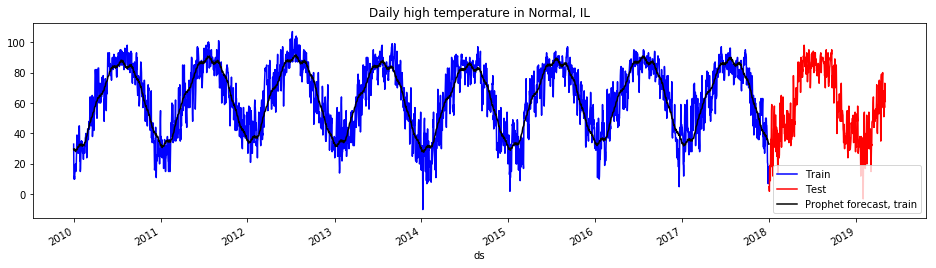

In [114]:
ax = train.plot(x='ds', y='y', color='blue', label='Train', figsize=(16,4))
test.plot(x='ds',y='y',color='red',label='Test',ax=ax)
train_forecast.plot(x='ds', y='yhat', color='black', label ='Prophet forecast, train', ax=ax)
plt.title('Daily high temperature in Normal, IL');

## Use time series metric: MAE (Mean Absolute Error)

In [66]:
train_mae = mean_absolute_error(train['y'], train_forecast['yhat'])
test_mae = mean_absolute_error(test['y'], test_forecast['yhat'])
train_mae, test_mae

(7.750483937276842, 8.738127402126453)

## Do time series cross-validation

#### Rob Hyndman & George Athanasopoulos, [_Forecasting: Principles and Practice_, Chapter 3.4](https://otexts.com/fpp2/accuracy.html), Evaluating forecast accuracy:

> A more sophisticated version of training/test sets is time series cross-validation. In this procedure, there are a series of test sets ... The corresponding training set consists only of observations that occurred _prior_ to the test set. 

> The following diagram illustrates the series of training and test sets, where the blue observations form the training sets, and the red observations form the test sets.

![](https://otexts.com/fpp2/fpp_files/figure-html/cv1-1.png)

> The forecast accuracy is computed by averaging over the test sets. This procedure is sometimes known as “evaluation on a rolling forecasting origin” because the “origin” at which the forecast is based rolls forward in time.

> With time series forecasting, one-step forecasts may not be as relevant as multi-step forecasts. In this case, the cross-validation procedure can be modified. Suppose that we are interested in models that produce good  4-step-ahead forecasts. Then the corresponding diagram is shown below.

![](https://otexts.com/fpp2/fpp_files/figure-html/cv4-1.png)

#### Prophet documentation: [Diagnostics](https://facebook.github.io/prophet/docs/diagnostics.html)

>Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values. 

>This figure illustrates a simulated historical forecast on the Peyton Manning dataset, where the model was fit to a initial history of 5 years, and a forecast was made on a one year horizon.

![](https://facebook.github.io/prophet/static/diagnostics_files/diagnostics_3_0.png)

> This cross validation procedure can be done automatically for a range of historical cutoffs using the `cross_validation` function. We specify the forecast horizon (`horizon`), and then optionally the size of the initial training period (`initial`) and the spacing between cutoff dates (`period`). 

> The output of `cross_validation` is a dataframe with the true values `y` and the out-of-sample forecast values `yhat`, at each simulated forecast date and for each cutoff date.

In [72]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(weather_model, initial='730 days',
                        horizon='365 days', period='180 days')

INFO:fbprophet:Making 11 forecasts with cutoffs between 2012-01-27 00:00:00 and 2016-12-31 00:00:00
/Users/dwightchurchill/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [75]:
from fbprophet.diagnostics import performance_metrics
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,37 days,92.603478,9.623070,7.439229,0.232932,0.787651
1,38 days,93.380388,9.663353,7.473780,0.230681,0.782638
2,39 days,96.020729,9.799017,7.586736,0.235785,0.773525
3,40 days,98.002974,9.899645,7.672974,0.242768,0.766006
4,41 days,96.888315,9.843186,7.652275,0.240363,0.768284
5,42 days,97.636253,9.881106,7.684656,0.236566,0.762155
6,43 days,100.014647,10.000732,7.763111,0.235929,0.758487
7,44 days,97.588572,9.878693,7.671893,0.228749,0.764183
8,45 days,96.996680,9.848689,7.644700,0.225812,0.769196
9,46 days,101.801005,10.089648,7.801853,0.233354,0.760538


## Use time series metrics: MSE, RMSE, MAE, MAPE

#### Prophet documentation: [Diagnostics](https://facebook.github.io/prophet/docs/diagnostics.html)

> The `performance_metrics` utility can be used to compute some useful statistics of the prediction performance ... The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), and coverage of the `yhat_lower` and `yhat_upper` estimates. These are computed on a rolling window of the predictions in `df_cv` after sorting by horizon ... By default 10% of the predictions will be included in each window, but this can be changed with the `rolling_window` argument.

> Cross validation performance metrics can be visualized with `plot_cross_validation_metric`, here shown for MAPE. Dots show the absolute percent error for each prediction in `df_cv`. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 5% are typical for predictions one month into the future, and that errors increase up to around 11% for predictions that are a year out.


![](https://facebook.github.io/prophet/static/diagnostics_files/diagnostics_12_0.png)

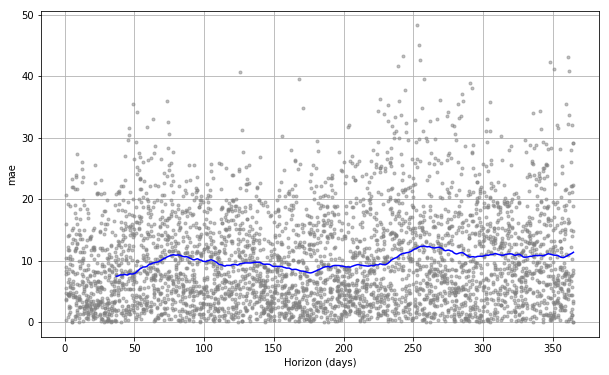

In [78]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

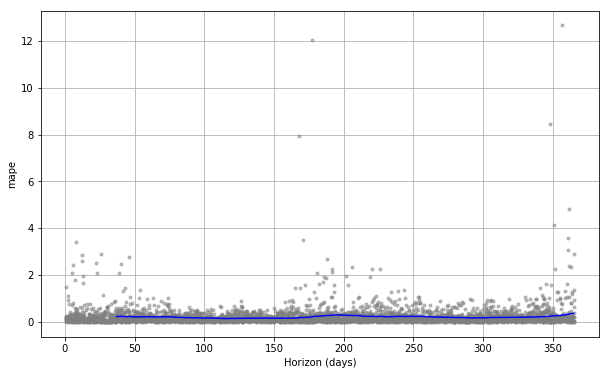

In [79]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

## Assignment

- Use the same data you chose for the previous lesson, or get new data.
- Do train/test split. Report your mean absolute error on the train and test set, for these forecasts:
  - Mean Baseline
  - Naive Baseline (Last Observation)
  - Prophet forecast (you can choose the parameters or use the defaults)
- Do time series cross-validation, using these Prophet functions:
  - cross_validation
  - performance_metrics
  - plot_cross_validation_metric
- Commit your notebook to your fork of the GitHub repo.

### Stretch Challenges
- **Share your visualizations on Slack!**
- Use the Wikimedia Pageviews API to get data.
- [Get daily weather station data](https://www.ncdc.noaa.gov/cdo-web/search) from the NOAA (National Oceanic and Atmospheric Administration). User Prophet to forecast the weather for your local area. 
- Adjust your forecasts with Prophet's [changepoints](https://facebook.github.io/prophet/docs/trend_changepoints.html) and [holidays](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html) options. In addition to Prophet's documentation, read Will Koehrsen's blog post, [Time Series Analysis in Python](https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a). **How do these parameters affect your error metrics?**
- Learn more about how Prophet works. Read the [tweestorm with animated GIFs](https://twitter.com/seanjtaylor/status/1123278380369973248) by Prophet developer Sean J. Taylor, or his [research paper](https://peerj.com/preprints/3190/).

In [102]:
project = 'en.wikipedia'
access = 'all-access'
agent = 'user'
article = 'Barkley_Marathons'
granularity = 'daily'
start = '2015101300'
end = '2015102700'

endpoint = f"/metrics/pageviews/per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}"
url = 'https://wikimedia.org/api/rest_v1' + endpoint
resp = requests.get(url)
assert resp.status_code == 200 

In [104]:
df = pd.DataFrame(resp.json()['items'])

In [106]:
df.head()

,access,agent,article,granularity,project,timestamp,views
0,all-access,user,Barkley_Marathons,daily,en.wikipedia,2015101300,94
1,all-access,user,Barkley_Marathons,daily,en.wikipedia,2015101400,194
2,all-access,user,Barkley_Marathons,daily,en.wikipedia,2015101500,113
3,all-access,user,Barkley_Marathons,daily,en.wikipedia,2015101600,100
4,all-access,user,Barkley_Marathons,daily,en.wikipedia,2015101700,91


In [109]:
df = df.rename(columns={'timestamp':'ds', 'views':'y'})
df['ds'] = pd.to_datetime(df['ds'], format='%Y%m%d%H')

In [110]:
df.head()

,access,agent,article,granularity,project,ds,y
0,all-access,user,Barkley_Marathons,daily,en.wikipedia,2015-10-13,94
1,all-access,user,Barkley_Marathons,daily,en.wikipedia,2015-10-14,194
2,all-access,user,Barkley_Marathons,daily,en.wikipedia,2015-10-15,113
3,all-access,user,Barkley_Marathons,daily,en.wikipedia,2015-10-16,100
4,all-access,user,Barkley_Marathons,daily,en.wikipedia,2015-10-17,91
